# Modelo no supervisado de clasificación de texto

## Introducción

En este notebook se presenta un modelo no supervisado de clasificación de texto. El modelo se basa en el uso de embeddings de palabras y clustering. Se utiliza el algoritmo de clustering KMeans para agrupar los textos en clusters.



In [12]:
### Librerias necesarias Doc2Vec

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

### Librerias necesarias para el preprocesamiento de texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

### Descargar stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')


### Otras librerias necesarias
import numpy as np
import pandas as pd
import re
import os

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


### 1.1 Modelo Doc2Vec

El modelo Doc2Vec es una extensión del modelo Word2Vec que agrega un vector adicional para cada documento en el corpus. Este vector adicional se entrena junto con los vectores de palabras y se utiliza para representar el contenido de un documento en un espacio vectorial. Esto permite comparar documentos y encontrar similitudes entre ellos. En este caso ocurre lo siguiente:

#### ¿Cómo funciona Doc2Vec?

Doc2Vec tiene dos enfoques principales:

1. **PV-DM (Distributed Memory):** Este modelo predice una palabra en el documento usando el contexto de palabras a su alrededor y un vector que representa al documento completo. En otras palabras:
   - Se toma un documento y se le asigna un vector único (el vector del documento).
   - Luego, junto con las palabras cercanas, este vector se usa para predecir una palabra en el documento.
   - Al entrenar el modelo, este vector se va ajustando para que capture mejor el significado del documento.

2. **PV-DBOW (Distributed Bag of Words):** Aquí se usa solo el vector del documento para predecir palabras al azar dentro del documento, sin tener en cuenta el contexto de palabras. Es más rápido, pero menos preciso.

En resumen, Doc2Vec es un modelo que entrena vectores para palabras y documentos al mismo tiempo. Estos vectores pueden ser usados luego para comparar documentos, encontrar similitudes entre ellos, o incluso para clasificarlos.

![Proceso doc2vec](../../Datos/Imágenes/doc2vec.png)


## 2. Cargar el texto

El dataset "es_tweets_laboral" de la colección "somosnlp-hackathon-2022" en Hugging Face está diseñado específicamente para el análisis de texto relacionado con temas laborales en español. Este dataset contiene tuits que abordan temas laborales, y es ideal para tareas de clasificación de texto, análisis de sentimientos, y otras aplicaciones de procesamiento de lenguaje natural (NLP) enfocadas en el ámbito laboral.

**Características del Dataset:**
- *Contenido*: Incluye tuits en español relacionados con temas laborales, como empleo, condiciones de trabajo, y derechos laborales.
- *Etiquetas*: Los tuits pueden estar etiquetados según el tema o el sentimiento, lo que facilita su uso en tareas de clasificación supervisada.
- *Aplicaciones*: Este dataset es útil para construir modelos que analicen la percepción de los usuarios sobre temas laborales, detectar tendencias en el mercado laboral, o identificar problemas comunes en el ámbito laboral.

El dataset es parte de un esfuerzo colaborativo durante el Hackathon de SomosNLP en 2022, que busca fomentar el desarrollo de tecnologías de procesamiento de lenguaje natural en español.



In [13]:
### Carga dataset desde huggingface
from datasets import load_dataset
import tqdm as notebook_tqdm
import re

# Cargando el dataset "es_tweets_laboral" desde Hugging Face
dataset = load_dataset("somosnlp-hackathon-2022/es_tweets_laboral")

# Explorando el contenido del dataset
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['text', 'intent', 'entities'],
        num_rows: 184
    })
    test: Dataset({
        features: ['text', 'intent', 'entities'],
        num_rows: 47
    })
})


In [14]:
train = dataset['train']
test = dataset['test']

# Explorando el contenido de los datos de entrenamiento

train_df = train.to_pandas()
test_df = test.to_pandas()
print("Shape of train data: ", train_df.shape)
print("Shape of test data: ", test_df.shape)

train_df.head()

Shape of train data:  (184, 3)
Shape of test data:  (47, 3)


,text,intent,entities
0,"ni siquiera decir ""palabras sucias"" te hace me...",abuso_autoridad,"[{'value': 'mal jefe,', 'entity': 'denuncia'}]"
1,"un amigo de mi hermana le comentó, dudo mucho ...",salario_precario,"[{'value': 'nos maltratan con el salario', 'en..."
2,respecto a los salarios: todos merecemos un sa...,salario_precario,[{'value': 'salario que nos permita vivir dign...
3,@FOVISSSTEmx @fovissste Gracias por su atenció...,derechos_laborales,[{'value': 'no es un esquema que favorezca al ...
4,"docentes venezolanos, perciben salarios insufi...",salario_precario,"[{'value': 'perciben salarios insuficientes', ..."


In [15]:
test_df.head()

,text,intent,entities
0,#OficinaDeEnvigado #TrabajoPorHoras #AbusoLabo...,explotacion_laboral,"[{'value': '#AbusoLaboral', 'entity': 'denunci..."
1,@MarianaLaActriz Oiga no la he visto cotizar e...,acoso_laboral,"[{'value': 'acoso sexual', 'entity': 'denuncia..."
2,La Asociación de Rectores Universitarios exigi...,salario_precario,"[{'value': 'ajuste del incremento salarial', '..."
3,"15).-Venezuela. Gobierno. Rusia. Presenta, en ...",salario_precario,[{'value': 'índice relativamente bajo de desem...
4,Después que Maduro bajó el salario mínimo de $...,salario_precario,"[{'value': 'bajó el salario mínimo', 'entity':..."


## 3. Preprocesamiento

Empezamos por cargar el dataset y realizar un preprocesamiento básico de los textos. En este caso, se eliminan las menciones a usuarios, los enlaces, y los caracteres especiales. Además, se convierten los textos a minúsculas y se eliminan las stopwords.

In [16]:
########## Preprocesamiento de texto ###############

def preprocess_text(text):
    # Eliminando caracteres especiales y números
    text = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', text, re.I|re.A)
    # Convertir a minúsculas
    text = text.lower()
    # eliminando stopwords
    stop_words = set(stopwords.words('spanish'))
    word_tokens = word_tokenize(text)
    text = [i for i in word_tokens if not i in stop_words]
    text = ' '.join(text)
    return text

# Aplicando la función de preprocesamiento a los datos de entrenamiento y prueba

train_df['text_pre'] = train_df['text'].apply(preprocess_text)

test_df['text_pre'] = test_df['text'].apply(preprocess_text)

train_df.head()

,text,intent,entities,text_pre
0,"ni siquiera decir ""palabras sucias"" te hace me...",abuso_autoridad,"[{'value': 'mal jefe,', 'entity': 'denuncia'}]",siquiera decir palabras sucias hace menos prof...
1,"un amigo de mi hermana le comentó, dudo mucho ...",salario_precario,"[{'value': 'nos maltratan con el salario', 'en...",amigo hermana comentó dudo vuelva trabajar uni...
2,respecto a los salarios: todos merecemos un sa...,salario_precario,[{'value': 'salario que nos permita vivir dign...,respecto salarios merecemos salario permita vi...
3,@FOVISSSTEmx @fovissste Gracias por su atenció...,derechos_laborales,[{'value': 'no es un esquema que favorezca al ...,fovissstemx fovissste gracias atención desgrac...
4,"docentes venezolanos, perciben salarios insufi...",salario_precario,"[{'value': 'perciben salarios insuficientes', ...",docentes venezolanos perciben salarios insufic...


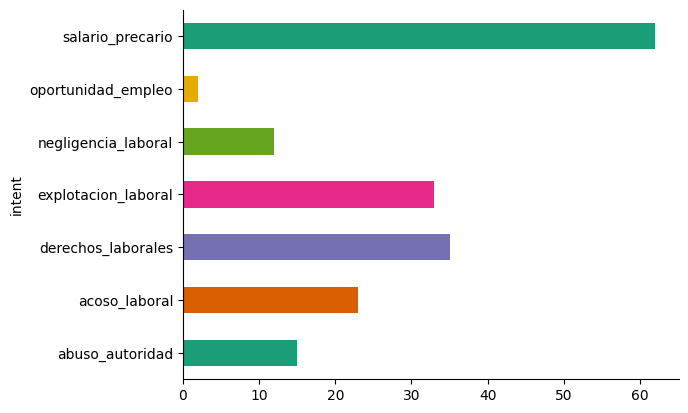

In [17]:
# @title intent

from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('intent').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## 4. Modelo de Clasificación de Texto

Una vez que hemos preprocesado los textos, podemos aplicar un modelo de clasificación no supervisado para agruparlos en categorías o clusters. En este caso, utilizaremos el algoritmo de clustering KMeans para agrupar los textos en clusters. AUnque primero debemos convertir los textos en vectores numéricos utilizando embeddings de palabras.


In [18]:
################## Entrenamiento de Word2Vec ####################

# Tokenizando el texto

train_df['text_tokens'] = train_df['text_pre'].apply(lambda x: x.split())
test_df['text_tokens'] = test_df['text_pre'].apply(lambda x: x.split())

train_df.head()

,text,intent,entities,text_pre,text_tokens
0,"ni siquiera decir ""palabras sucias"" te hace me...",abuso_autoridad,"[{'value': 'mal jefe,', 'entity': 'denuncia'}]",siquiera decir palabras sucias hace menos prof...,"[siquiera, decir, palabras, sucias, hace, meno..."
1,"un amigo de mi hermana le comentó, dudo mucho ...",salario_precario,"[{'value': 'nos maltratan con el salario', 'en...",amigo hermana comentó dudo vuelva trabajar uni...,"[amigo, hermana, comentó, dudo, vuelva, trabaj..."
2,respecto a los salarios: todos merecemos un sa...,salario_precario,[{'value': 'salario que nos permita vivir dign...,respecto salarios merecemos salario permita vi...,"[respecto, salarios, merecemos, salario, permi..."
3,@FOVISSSTEmx @fovissste Gracias por su atenció...,derechos_laborales,[{'value': 'no es un esquema que favorezca al ...,fovissstemx fovissste gracias atención desgrac...,"[fovissstemx, fovissste, gracias, atención, de..."
4,"docentes venezolanos, perciben salarios insufi...",salario_precario,"[{'value': 'perciben salarios insuficientes', ...",docentes venezolanos perciben salarios insufic...,"[docentes, venezolanos, perciben, salarios, in..."


In [19]:
# Entrenando el modelo Doc2Vec

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_df['text_tokens'])]

# Definiendo el modelo Doc2Vec

model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

# Guardando el modelo entrenado

model.save("doc2vec.model")


In [21]:
documents

[TaggedDocument(words=['siquiera', 'decir', 'palabras', 'sucias', 'hace', 'menos', 'profesionallo', 'verdaderamente', 'quita', 'profesionalismo', 'ser', 'corrupto', 'mala', 'gente', 'mal', 'jefe', 'patán', 'falta', 'compromiso', 'etc', 'afecta', 'profesionalismo', 'manera', 'lleves', 'cabello', 'vida', 'personal'], tags=[0]),
 TaggedDocument(words=['amigo', 'hermana', 'comentó', 'dudo', 'vuelva', 'trabajar', 'universidad', 'gusta', 'hago', 'maltratan', 'salario', 'quiero', 'formar', 'familia', 'gran', 'verdad', 'trabajadores', 'maquievalicamente', 'maltratados', 'injusto', 'gobierno'], tags=[1]),
 TaggedDocument(words=['respecto', 'salarios', 'merecemos', 'salario', 'permita', 'vivir', 'dignamente', 'bajo', 'si', 'servicios', 'públicos', 'realmente', 'eficientes', 'pagar', 'escuela', 'salud', 'carro'], tags=[2]),
 TaggedDocument(words=['fovissstemx', 'fovissste', 'gracias', 'atención', 'desgraciadamente', 'esquema', 'favorezca', 'trabajador', 'agradezco', 'atención'], tags=[3]),
 Tagge

In [26]:
# Cargando el modelo entrenado

model = Doc2Vec.load("doc2vec.model")

# Obteniendo el vector de una palabra

model.wv['trabajo']



array([ 8.30981508e-03, -4.18678299e-03,  9.53014754e-03,  8.39761365e-03,
       -3.28295259e-03, -1.04595709e-03,  4.60452121e-03, -2.77465675e-03,
       -7.66448723e-03, -7.02042459e-03, -1.46383187e-03, -1.55715563e-03,
        4.08554450e-03, -2.30204733e-03, -1.41774944e-03,  2.22145906e-03,
        6.55516610e-03, -1.08109124e-03, -6.36265846e-03, -1.05379950e-02,
        1.23145885e-03,  7.29085272e-03,  2.53156433e-03, -8.71880166e-03,
       -7.94063788e-03,  7.22450204e-03, -4.13554488e-03,  5.75740077e-03,
       -8.48510396e-03,  8.22011288e-03, -4.69418848e-03,  4.43476019e-03,
       -1.13812066e-03, -5.38124517e-03, -2.72100163e-03,  4.96823986e-06,
       -5.74563863e-03, -2.30706204e-03, -8.05798639e-03,  2.21237796e-03,
        1.02552734e-02, -2.84707453e-03, -1.38335372e-03,  1.72053732e-03,
        9.08984244e-03, -6.30480796e-03, -6.79755583e-03, -3.32454802e-03,
        9.61219147e-03,  1.50724058e-03, -8.70467070e-03, -8.53400794e-04,
        9.48749762e-03, -

In [31]:
## Vector de un documento

model.dv[0]

array([-0.00539043, -0.00556149, -0.00976715,  0.00880718,  0.00450014,
       -0.00068459, -0.0098928 , -0.00416905, -0.01115361,  0.00178014,
        0.002023  ,  0.00375246, -0.00456657, -0.00306364, -0.00387647,
       -0.00927906,  0.00354417,  0.00853564, -0.00972067, -0.00430867,
       -0.00288424,  0.00315415, -0.00514644,  0.00262102,  0.00602406,
       -0.00784437, -0.00895732, -0.01051707,  0.00391721, -0.00964266,
        0.00731105,  0.00753349, -0.00675907, -0.00365784, -0.00086991,
        0.00240118, -0.00181737, -0.00956504, -0.00403637,  0.00142718,
       -0.00142965, -0.00787341,  0.00413647, -0.00994037,  0.00269197,
       -0.00501707,  0.00071499, -0.00254041,  0.00562986, -0.00774554,
       -0.00206784,  0.00014945, -0.00673668, -0.00664428, -0.00279295,
        0.00951893, -0.00115141,  0.00299559, -0.00668852,  0.00927941,
        0.00273076,  0.00992534,  0.00374052, -0.00374352,  0.00207023,
       -0.00255242,  0.00633214,  0.00279653, -0.00288232, -0.00

In [23]:

# Obteniendo las palabras más similares a una palabra

model.wv.most_similar('abuso')

[('tv', 0.3388918340206146),
 ('páginas', 0.33612701296806335),
 ('inspección', 0.32902324199676514),
 ('casa', 0.30751997232437134),
 ('gómezpalacios', 0.3025720715522766),
 ('interiorizado', 0.3020995855331421),
 ('fernand', 0.28665125370025635),
 ('cuantamugre', 0.28345754742622375),
 ('terminó', 0.27055153250694275),
 ('maldonado', 0.2618955671787262)]

In [27]:
# Obteniendo la similitud entre dos palabras

model.wv.similarity('trabajo', 'empleo')


0.10175322

In [28]:
#### Hacemos un clustering de los tweets con KMeans

from sklearn.cluster import KMeans

# Obteniendo los vectores de los tweets

vectors = [model.infer_vector(doc) for doc in train_df['text_tokens']]

# Definiendo el modelo KMeans

kmeans = KMeans(n_clusters=5, random_state=0)

# Entrenando el modelo KMeans

kmeans.fit(vectors)

# Obteniendo las etiquetas de los clusters

train_df['cluster'] = kmeans.labels_

# Explorando los clusters

train_df['cluster'].value_counts()



,count
cluster,
3,53
2,51
1,36
4,23
0,21


In [29]:
### Veamos los tweets de un cluster

pd.set_option('display.max_colwidth', None)

train_df[train_df['cluster'] == 0]['text'].head(10)

,text
18,"Se aumentará un 15% la cuantía del Ingreso Mínimo Vital y se ampliarán los beneficios del bono social eléctrico con el objetivo de que hasta dos millones de familias se encuentren bajo su paraguas.\n\nSalario social de Rajoy, lo otro igual."
26,"🔴Tras denuncia, a través de la @DirecDelTrabajo, se ha iniciado un proceso de fiscalización por eventual irregularidad al exigir a trabajador comprar vestimenta para sus labores👷‍♂️\n\nEsto infringiría normativa laboral expresada en dictámenes previos👉https://t.co/WRsJg3dT5g https://t.co/KQ6EgTiHAJ https://t.co/fKnhzCj4ps"
27,algunas trabajadoras del hogar viven condiciones que se equiparan a las de la trata de personas en su modalidad de explotación laboral. la pandemia agravó su situación: cerca de 300 mil personas de este sector se quedaron sin empleo. escribo en @milenio
36,⚠️¿Se van a quedar con tus ahorros? \n\nLa Comisión de Derechos Fundamentales rechazó una indicación presentada por la convencional Rocío Cantuarias que buscaba garantizar la propiedad de cada trabajador sobre su fondo de pensiones y la posibilidad de que su familia lo herede. https://t.co/6kKdqg6fgs
58,"Manuela Muñoz, secretaria general del Sindicato trabajadoras casas particulares de E.R: “nos preocupa la 5ta categoría porque con el último aumento, ellos quedan con el salario más bajo. Por eso pedíamos esta reunión enseguida” #Aumento"
59,"@7Elisa24 @martinPtelesca @smazzarovich Cómo pienso diferente decís que me creo mentiras. Argumenta,yo te digo que el salario bajó mientras los sueldos de jerarcas públicos aumentó,se ahorra para bajar el déficit pero se exonera a los canales de tv de impuestos,el pib crece y los sueldos y jubilaciones bajan, explícame https://t.co/N8DHJiGgSq"
71,"No ajusten al Pueblo trabajador. Es hora de ser firmes con los fuertes para que Argentina pueda crecer. Sanciones a empresarios especuladores, a medios de comunicación difusores de odio, reforma a la justicia.\n\n#LaCallePideJusticiaSocial #SoberaniaEIndependencia #Emancipacion"
81,"@7Elisa24 @martinPtelesca @smazzarovich Cómo pienso diferente decís que me creo mentiras. Argumenta,yo te digo que el salario bajó mientras los sueldos de jerarcas públicos aumentó,se ahorra para bajar el déficit pero se exonera a los canales de tv de impuestos,el pib crece y los sueldos y jubilaciones bajan, explícame https://t.co/N8DHJiGgSq"
96,"@RolandoCastroSv Para ahorrar las empresas grandes subcontratan a ""coyotes"" de la construcción y éstos a obreros q devengan un salario muy bajo por largas jornadas y de paso no dan prestaciones ni seguro social y además no pagan impuesto por el dinero malhabido q reciben éstos coyotes..."
100,le gane la demanda a mi ex colegio. el despido fue injustificado. nunca más se limpiarán la boca con mi nombre. decir que porque fui capaz de visibilizar la mala gestión y hablar de frente defendiendo mis derechos y los de mis colegas me convierto en una persona oposicionista.pff


In [30]:
### Veamos el centroide de cada cluster

for i in range(5):
    print("Cluster ", i)
    print(model.wv.most_similar(positive=[kmeans.cluster_centers_[i]], topn=10))
    print("\n\n")

Cluster  0
[('salum', 0.3494351804256439), ('locales', 0.34332677721977234), ('salario', 0.302868127822876), ('si', 0.2971515953540802), ('acumular', 0.2951195240020752), ('hoy', 0.29315394163131714), ('empecé', 0.2894522547721863), ('siempre', 0.28301140666007996), ('ayúdenme', 0.28278157114982605), ('mujer', 0.28251728415489197)]



Cluster  1
[('salario', 0.3889075815677643), ('salum', 0.3233303725719452), ('sacando', 0.32325148582458496), ('uexternado', 0.3212044835090637), ('paga', 0.30761072039604187), ('planteamos', 0.30562010407447815), ('peor', 0.30367720127105713), ('si', 0.29951366782188416), ('residentepacienteusuario', 0.298555463552475), ('siempre', 0.2930024266242981)]



Cluster  2
[('lucha', 0.4237067997455597), ('si', 0.3562796115875244), ('laboral', 0.3481588065624237), ('salario', 0.310628205537796), ('lugar', 0.3061029016971588), ('gobierno', 0.2960722744464874), ('municipal', 0.2932620346546173), ('justifico', 0.2861025333404541), ('compaeros', 0.2859939634799957)

## NUEVO EJERCICIO SIN PROCESAMIENTO DE TEXTO

In [39]:
## Importamos el dataset de reviews de Booking
DF=pd.read_csv('https://raw.githubusercontent.com/Izainea/nlp_ean/refs/heads/main/Datos/Datos%20Crudos/reviews_booking.csv')
DF

<ipython-input-39-ec6d337b8bd4>:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  DF=pd.read_csv('https://raw.githubusercontent.com/Izainea/nlp_ean/refs/heads/main/Datos/Datos%20Crudos/reviews_booking.csv')


,Unnamed: 0,País,Acomodación,Noches,Fecha hospedaje,Grupo viaje,Fecha reseña,Titulo,Calificación,Cosas Positivas,Cosas Negativas,reseña
0,0,Venezuela,NaN,2 noches,julio de 2023,En pareja,31 de julio de 2023,Excepcional,10,"Fue la Mejor Opción que pudimos haber tomado en Bogotá lo recomendamos mil % al regresar sin duda contactaremos al anfitrión porque fue todo un encanto. Limpio, Cómodo, Cercano a Todo, Súper Seguro fue increíble nuestra estancia",NaN,Sí
1,1,Colombia,NaN,4 noches,octubre de 2024,Persona que viaja sola,23 de octubre de 2024,Fantástica,10,"Ubicación, comodidades y limpieza",NaN,Sí
2,2,Colombia,NaN,1 noche,octubre de 2024,Persona que viaja sola,15 de octubre de 2024,Excepcional,10,"El lugar esta muy bien ubicado, el apartamento muy bonito y limpio. El afintrion fue supremamente atento a todo lo que necesité, totalmente un lugar recomendable.",NaN,Sí
3,3,Colombia,NaN,1 noche,agosto de 2024,En pareja,20 de agosto de 2024,Gran apartamento en una gran ubicación.,10,Todo estuvo perfecto. La ubicación y la relación calidad-precio fueron lo mejor.,NaN,Sí
4,4,Colombia,NaN,3 noches,marzo de 2024,En pareja,27 de marzo de 2024,Excepcional,10,"Es muy cómodo y acogedor, la atención es excelente. El espacio perfecto para descansar y disfrutar del centro histórico de Bogotá.",NaN,Sí
...,...,...,...,...,...,...,...,...,...,...,...,...
438208,438208,Estados Unidos,Apartamento Suite,1 noche,septiembre de 2024,En familia,22 de octubre de 2024,Fantástico,"9,0",NaN,NaN,No
438209,438209,Colombia,Apartamento de 1 dormitorio,1 noche,octubre de 2024,Persona que viaja sola,9 de octubre de 2024,Excepcional,10,NaN,NaN,No
438210,438210,México,Apartamento de 1 dormitorio,4 noches,agosto de 2024,Persona que viaja sola,6 de septiembre de 2024,Pésimo,"1,0",No me pareció nada,"No obstante que dos días antes de mi llegada avise que llegaría a medianoche, me indicaron que si, sin embargo llegue y estaba ocupado por lo cual tuve que irme a las 2:00 am a buscar un lugar. Por que si dos días antes avise de mi hora de llegada y que les podría hacer una transferencia, me indicaron que no había problema por la hora de llegar y que pagara cuando arribara la lugar, soy de México y que pésimo servicio ofrecieron.",Sí
438211,438211,Colombia,Apartamento de 1 dormitorio,2 noches,julio de 2024,En pareja,22 de julio de 2024,Excepcional,10,NaN,NaN,No


In [40]:
## Función para contar palabras

def contar_stopwords(text):
    words = text.split()  # Divide el texto en palabras
    return sum(1 for word in words if word.lower() in stopwords_esp)

In [41]:
stopwords_esp = stopwords.words('spanish') ## Palabras vacias en español

In [42]:
DF['Calificación']=DF['Calificación'].str.replace(',','.').astype(float)

In [43]:
DF_inicial=DF[DF['Calificación']<=7]

DF_inicial=DF_inicial[DF_inicial['País'].isin(['Colombia'])]['Cosas Negativas']
DF_inicial=DF_inicial[DF_inicial.fillna('').apply(len)>60]

DF_inicial = DF_inicial[DF_inicial.apply(contar_stopwords) > 4]

DF_inicial = DF_inicial.sample(7500)

In [44]:
DF_Final=pd.DataFrame()

DF_Final['Comentarios']=DF_inicial
DF_Final['Clas']='Negativos'

In [45]:
DF_Final

,Comentarios,Clas
358357,"La habitacion que nos entregaron, estaba mal aseada, toallas de manos uscuas y udadas, no habian jabones, no habian toallas de ducha y no calentaba el agua",Negativos
283703,"Hice una reservación para cenar con mi familia el 31 de diciembre a las 8:30 pm, no había tal cosa. No nos advirtieron que no habría nada especial, simplemente había un buffet para todos, sin ninguna decoración especial.\n\nUna botella de agua del minibar de la más pequeñas $6.500, es el valor de seis botellas de las mismas en el mercado, es un precio exagerado.",Negativos
417993,"Se paga por un aseo que no hacen, piden que limpies las manchas o te hacen pagar por manchas que supuestamente no quitan, se confronta esto y la respuesta es que vuelven a poner todo sin lavarlo. Ell buffet del desayuno no cuenta con protocolos de aseo, cualquier huesped puede servir los alimentos y por lo tanto no hay un control de seguridad alimentaria.",Negativos
11504,"No habia ollas sartenes (y en las fotos se ven),\nLas personas de recepción no eran amables\nNo tenia cafetera, tuvimos que pedirla\nEl desayuno era muy pobre",Negativos
399983,"Hacían mucho ruido en general, se escucha todo lo que pasa en el pasillo y el servicio de limpieza es muy bulloso a lo largo de la mañana.",Negativos
...,...,...
175973,"La calidad de la habitación, reservamos una cama doble y cuando llegamos había dos cañas sencillas, el sitio es muy pequeño y ruidoso, desde la 2 de la mañana haciendo ruidos sin dejar dormir, el desayuno fue súper malo tanto que dieron unos huevos con medio pan, definitivamente no se recomienda",Negativos
93801,"No ofrecen desayuno, el TV no servía, la atención no fue amable",Negativos
213772,"La calidad del desayuno ha bajado, el chocolate solo agua, el jugo agrio y fermentado, y la porción de huevos muy pequeña, se pudieron omelette y no tenían nada de omelette",Negativos
417965,Tienen una terrible gerencia y no asumieron un crédito que tenía,Negativos


In [46]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(DF_Final, test_size=0.2, random_state=42) # 80% train, 20% test

# Imprimir las formas de los conjuntos de datos resultantes
print("Forma de los datos de entrenamiento:", train_data.shape)
print("Forma de los datos de prueba:", test_data.shape)

Forma de los datos de entrenamiento: (6000, 2)
Forma de los datos de prueba: (1500, 2)


In [51]:
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminando stopwords
    word_tokens = word_tokenize(text)
    return text

# Aplicando la función de preprocesamiento a los datos de entrenamiento y prueba

train_data['text_pre'] = train_data['Comentarios'].apply(preprocess_text)

test_data['text_pre'] = test_data['Comentarios'].apply(preprocess_text)

train_data.head()

,Comentarios,Clas,text_pre
146902,"La mala atención y trato grosero de parte de una señora de edad que atendia la recepción, hube mejor atención del señor vigilante de turno que la de esta señora para con los huésped que era mi familia, claro si grosería y prepotencia aludía que era la gerente....lamentable y pesimo para fidelizar clientes.",Negativos,"la mala atención y trato grosero de parte de una señora de edad que atendia la recepción, hube mejor atención del señor vigilante de turno que la de esta señora para con los huésped que era mi familia, claro si grosería y prepotencia aludía que era la gerente....lamentable y pesimo para fidelizar clientes."
253463,"de resto el personal parecen sacados de una bolsa con picantes , super mala actitud, cero atención al cliente , el DESAYUNO malo , huevos secos sin sabor , 4 días lo mismo , si llegas tipo 9 ya no hay nada de comer y los de cocina te cierran la puerta , la habitación la nevera no enfriaba, se les olvidaba dejar jabón, papel higiénico en el baño , mil horas para q saliera agua caliente malo Etc.. REPITO LO ÚNICO QUE RESCATE FUE LA RECEPCIONISTA VENEZUELA UN AMOR.",Negativos,"de resto el personal parecen sacados de una bolsa con picantes , super mala actitud, cero atención al cliente , el desayuno malo , huevos secos sin sabor , 4 días lo mismo , si llegas tipo 9 ya no hay nada de comer y los de cocina te cierran la puerta , la habitación la nevera no enfriaba, se les olvidaba dejar jabón, papel higiénico en el baño , mil horas para q saliera agua caliente malo etc.. repito lo único que rescate fue la recepcionista venezuela un amor."
105715,"El servicio, la recepcionista que nos recibio no btindo buena atención, no nos ayudó abrir la puerta, no nos explico el funcionamiento del tv, nos quedó debiendo $1.000 y no nos entrego toallas.",Negativos,"el servicio, la recepcionista que nos recibio no btindo buena atención, no nos ayudó abrir la puerta, no nos explico el funcionamiento del tv, nos quedó debiendo $1.000 y no nos entrego toallas."
240217,"esta en obra, mucho ruido, esta catalogado con 5 estrellas pero esperaba mucho mas",Negativos,"esta en obra, mucho ruido, esta catalogado con 5 estrellas pero esperaba mucho mas"
130045,"Que me duche dos días con agua fría, cuando lo comenté la chica me dijo que a veces se desconecta no se qué cosa y se demora en calentar como un día, también que cobran los desayunos adicionales, y sirven poquito, y lo charro es que tiene un valor 20.000mil pesos como si por lo menos ameritan pagarlos, todo es súper costoso hasta el agua, una botella no deberían de venderla en 4.000mil pesos",Negativos,"que me duche dos días con agua fría, cuando lo comenté la chica me dijo que a veces se desconecta no se qué cosa y se demora en calentar como un día, también que cobran los desayunos adicionales, y sirven poquito, y lo charro es que tiene un valor 20.000mil pesos como si por lo menos ameritan pagarlos, todo es súper costoso hasta el agua, una botella no deberían de venderla en 4.000mil pesos"


In [53]:
################## Entrenamiento de Word2Vec ####################

# Tokenizando el texto

train_data['text_tokens'] = train_data['text_pre'].apply(lambda x: x.split())
test_data['text_tokens'] = test_data['text_pre'].apply(lambda x: x.split())

train_data.head()

,Comentarios,Clas,text_pre,text_tokens
146902,"La mala atención y trato grosero de parte de una señora de edad que atendia la recepción, hube mejor atención del señor vigilante de turno que la de esta señora para con los huésped que era mi familia, claro si grosería y prepotencia aludía que era la gerente....lamentable y pesimo para fidelizar clientes.",Negativos,"la mala atención y trato grosero de parte de una señora de edad que atendia la recepción, hube mejor atención del señor vigilante de turno que la de esta señora para con los huésped que era mi familia, claro si grosería y prepotencia aludía que era la gerente....lamentable y pesimo para fidelizar clientes.","[la, mala, atención, y, trato, grosero, de, parte, de, una, señora, de, edad, que, atendia, la, recepción,, hube, mejor, atención, del, señor, vigilante, de, turno, que, la, de, esta, señora, para, con, los, huésped, que, era, mi, familia,, claro, si, grosería, y, prepotencia, aludía, que, era, la, gerente....lamentable, y, pesimo, para, fidelizar, clientes.]"
253463,"de resto el personal parecen sacados de una bolsa con picantes , super mala actitud, cero atención al cliente , el DESAYUNO malo , huevos secos sin sabor , 4 días lo mismo , si llegas tipo 9 ya no hay nada de comer y los de cocina te cierran la puerta , la habitación la nevera no enfriaba, se les olvidaba dejar jabón, papel higiénico en el baño , mil horas para q saliera agua caliente malo Etc.. REPITO LO ÚNICO QUE RESCATE FUE LA RECEPCIONISTA VENEZUELA UN AMOR.",Negativos,"de resto el personal parecen sacados de una bolsa con picantes , super mala actitud, cero atención al cliente , el desayuno malo , huevos secos sin sabor , 4 días lo mismo , si llegas tipo 9 ya no hay nada de comer y los de cocina te cierran la puerta , la habitación la nevera no enfriaba, se les olvidaba dejar jabón, papel higiénico en el baño , mil horas para q saliera agua caliente malo etc.. repito lo único que rescate fue la recepcionista venezuela un amor.","[de, resto, el, personal, parecen, sacados, de, una, bolsa, con, picantes, ,, super, mala, actitud,, cero, atención, al, cliente, ,, el, desayuno, malo, ,, huevos, secos, sin, sabor, ,, 4, días, lo, mismo, ,, si, llegas, tipo, 9, ya, no, hay, nada, de, comer, y, los, de, cocina, te, cierran, la, puerta, ,, la, habitación, la, nevera, no, enfriaba,, se, les, olvidaba, dejar, jabón,, papel, higiénico, en, el, baño, ,, mil, horas, para, q, saliera, agua, caliente, malo, etc.., repito, lo, único, que, rescate, fue, la, recepcionista, venezuela, un, amor.]"
105715,"El servicio, la recepcionista que nos recibio no btindo buena atención, no nos ayudó abrir la puerta, no nos explico el funcionamiento del tv, nos quedó debiendo $1.000 y no nos entrego toallas.",Negativos,"el servicio, la recepcionista que nos recibio no btindo buena atención, no nos ayudó abrir la puerta, no nos explico el funcionamiento del tv, nos quedó debiendo $1.000 y no nos entrego toallas.","[el, servicio,, la, recepcionista, que, nos, recibio, no, btindo, buena, atención,, no, nos, ayudó, abrir, la, puerta,, no, nos, explico, el, funcionamiento, del, tv,, nos, quedó, debiendo, $1.000, y, no, nos, entrego, toallas.]"
240217,"esta en obra, mucho ruido, esta catalogado con 5 estrellas pero esperaba mucho mas",Negativos,"esta en obra, mucho ruido, esta catalogado con 5 estrellas pero esperaba mucho mas","[esta, en, obra,, mucho, ruido,, esta, catalogado, con, 5, estrellas, pero, esperaba, mucho, mas]"
130045,"Que me duche dos días con agua fría, cuando lo comenté la chica me dijo que a veces se desconecta no se qué cosa y se demora en calentar como un día, también que cobran los desayunos adicionales, y sirven poquito, y lo charro es que tiene un valor 20.000mil pesos como si por lo menos ameritan pagarlos, todo es súper costoso hasta el agua, una botella no deberían de venderla en 4.000mil pesos",Negativos,"que me duche dos días con agua fría, cuando lo comenté la chica me dijo que a veces se desconecta no 

In [56]:
# Entrenando el modelo Doc2Vec

documents_data = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_data['text_tokens'])]

# Definiendo el modelo Doc2Vec

model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

# Guardando el modelo entrenado

model.save("doc2vec.model")

In [57]:
documents_data

[TaggedDocument(words=['la', 'mala', 'atención', 'y', 'trato', 'grosero', 'de', 'parte', 'de', 'una', 'señora', 'de', 'edad', 'que', 'atendia', 'la', 'recepción,', 'hube', 'mejor', 'atención', 'del', 'señor', 'vigilante', 'de', 'turno', 'que', 'la', 'de', 'esta', 'señora', 'para', 'con', 'los', 'huésped', 'que', 'era', 'mi', 'familia,', 'claro', 'si', 'grosería', 'y', 'prepotencia', 'aludía', 'que', 'era', 'la', 'gerente....lamentable', 'y', 'pesimo', 'para', 'fidelizar', 'clientes.'], tags=[0]),
 TaggedDocument(words=['de', 'resto', 'el', 'personal', 'parecen', 'sacados', 'de', 'una', 'bolsa', 'con', 'picantes', ',', 'super', 'mala', 'actitud,', 'cero', 'atención', 'al', 'cliente', ',', 'el', 'desayuno', 'malo', ',', 'huevos', 'secos', 'sin', 'sabor', ',', '4', 'días', 'lo', 'mismo', ',', 'si', 'llegas', 'tipo', '9', 'ya', 'no', 'hay', 'nada', 'de', 'comer', 'y', 'los', 'de', 'cocina', 'te', 'cierran', 'la', 'puerta', ',', 'la', 'habitación', 'la', 'nevera', 'no', 'enfriaba,', 'se', '

In [58]:
# Cargando el modelo entrenado

model = Doc2Vec.load("doc2vec.model")

# Obteniendo el vector de una palabra

model.wv['habitación']

array([-0.17472142,  0.26588616,  1.3487321 , -0.4768664 ,  0.11801417,
       -1.8708847 ,  1.1397948 ,  0.98079395, -0.57506573, -0.48662302,
       -1.2858118 , -1.757492  ,  0.8392233 ,  0.01320868, -0.03124924,
       -1.2587607 ,  0.61370826,  0.04809178, -0.00287537, -2.6355882 ,
        0.87874645, -0.5430306 ,  0.62863433, -0.7971999 , -0.954808  ,
        0.30055818, -0.32150784,  0.09548786, -0.06556022, -0.9145822 ,
        0.5229738 ,  0.55982655,  0.27220654, -0.87149096,  0.78442204,
        1.4297202 ,  1.0998287 , -0.4056794 ,  0.40956184, -1.3257884 ,
        0.51558685, -1.6522893 ,  0.890284  ,  0.5111013 ,  0.63087595,
       -0.41260445, -0.2597977 , -0.8717702 , -0.1880431 ,  0.44101807,
        0.29904503,  0.1411659 ,  0.8337281 , -0.56591964, -0.16255803,
        0.16933106, -0.2885075 ,  0.02300278, -1.1497768 ,  0.86612624,
        1.0635346 , -0.94387287, -0.03507454, -0.31424147,  0.08033376,
        0.27528983, -0.3717574 ,  0.691627  , -0.6019792 ,  0.58

In [59]:
model.dv[0]

array([-0.05865053,  0.08427243,  0.07731855, -0.00365414, -0.03674758,
       -0.13042259, -0.00780148,  0.25462064, -0.2301366 , -0.03612072,
       -0.19542943, -0.15283275, -0.02488127,  0.00854336,  0.01663353,
       -0.0759269 ,  0.1654018 ,  0.01819599, -0.12674084, -0.27862313,
        0.04934454,  0.05886644,  0.1399969 ,  0.01338965, -0.04739291,
        0.05662848, -0.09767177, -0.09358061, -0.27531302, -0.01657255,
        0.12223884, -0.00996619,  0.03184906, -0.13215905,  0.0310876 ,
        0.15305638,  0.05167321, -0.0987642 , -0.0544893 , -0.02288806,
        0.07679262, -0.18580446, -0.04490427,  0.04761089,  0.00435671,
       -0.08683075, -0.06910992, -0.13264243, -0.04138757, -0.0214273 ,
        0.07638812, -0.13202831, -0.11051292, -0.08588576, -0.22280139,
        0.01897472, -0.01921458, -0.10701459, -0.14849943,  0.00760407,
        0.0976493 ,  0.06548572, -0.02031812,  0.0224395 , -0.01876188,
        0.23298304,  0.09833907, -0.02522866, -0.23721966, -0.03

In [63]:
# Obteniendo las palabras más similares a una palabra

model.wv.most_similar('servicio')

[('restaurante', 0.9128207564353943),
 ('servicio,', 0.8888956904411316),
 ('servicio.', 0.8777831792831421),
 ('trato', 0.8772287964820862),
 ('desayuno,', 0.8749154806137085),
 ('personal.', 0.8721155524253845),
 ('wifi', 0.8672840595245361),
 ('personal,', 0.8644230365753174),
 ('personal', 0.8623803853988647),
 ('control', 0.8615429401397705)]

In [64]:
model.wv.similarity('cobijas', 'baño')

0.6357707

In [65]:
#### Hacemos un clustering de los tweets con KMeans

from sklearn.cluster import KMeans

# Obteniendo los vectores de los tweets

vectors = [model.infer_vector(doc) for doc in train_data['text_tokens']]

# Definiendo el modelo KMeans

kmeans = KMeans(n_clusters=5, random_state=0)

# Entrenando el modelo KMeans

kmeans.fit(vectors)

# Obteniendo las etiquetas de los clusters

train_data['cluster'] = kmeans.labels_

# Explorando los clusters

train_data['cluster'].value_counts()

,count
cluster,
0,3538
4,1180
2,946
1,315
3,21


In [76]:
### Veamos los tweets de un cluster

pd.set_option('display.max_colwidth', None)

train_data[train_data['cluster'] == 0]['Comentarios'].head(10)

,Comentarios
240217,"esta en obra, mucho ruido, esta catalogado con 5 estrellas pero esperaba mucho mas"
26316,"que las chicas dl aseo son muy ruidosas, escuchan música con el volumen muy alto y hablan a toda hora,"
329075,"No había agua, no encontraban la reserva y no funciona como hotel. Es un motel de 40 mil pesos entraron hasta en una habitación. Desaseo total"
288225,"parece mas un bar que un hotel, no se pudo descansar música a todo volumen, no se respetan reglas"
256544,"No estaba lista la habitación, mala atención del servicio, tienen negocio con los taxis del hotel para cobrar precios extravagantes"
336780,El agua estaba fría !\nOpciones de desayuno no eran suficientes
18810,Me hicieron levantarme a las 2 am a mover el vehículo en el parqueadero
124846,"El baño con hidromasaje estaba sucio, olía a feo como a tubería.\nEl lugar es muy frío y no había calefacción."
430168,"Habia pagado desayuno pero no me lo proporcionaron, la cama estaba muy dura, y la regadera estaba sucia."
306199,Qué no estaba incluído el impuesto en el valor de la aplicación
